# 1.2. Individual planet distribution analysis

Now, we investigate the planet's radius/mass distribution.  
For the Transit case, we plot the mass distribution for each of the 150 test planets. Default final estimate is the distribution average.  
For the RV case, we plot the bivariate mass/radius distribution for each of the 150 test planets. We also add the final estimate as the weighted average after convolution.

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor

from knnxkde import KNNxKDE
from utils import normalization, renormalization, compute_epsilon, importance_sampling
from utils import convolution_TLG2020_fix_incl
from GAIN.gain import gain

2024-03-09 13:49:48.339721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
rv_dists = np.load('data/mdists__mask[001111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')
transit_dists = np.load('data/mdists__mask[101111]Ndist2000_2018-08-23_mcsteps3000_loss-0.32_multitrain0_0.npy')

In [3]:
colnames = ['idx', 'pl_name', 'pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']
all_planets = pd.read_csv('data/NEA_radmasstpersmasspnum.csv', names=colnames, sep=',', skiprows=1)

rs = np.random.RandomState(12345)
dataidx = rs.permutation(all_planets.shape[0])  # it's the very same, I have checked

train_names = all_planets['pl_name'][dataidx[0:400]]
test_names = all_planets['pl_name'][dataidx[400:]]

true_masses = np.array(all_planets.iloc[dataidx[400:]]['pl_bmassj'])
true_radii = np.array(all_planets.iloc[dataidx[400:]]['pl_radj'])

In [4]:
def generate_planet_bio(n):
    cur_data = all_planets.iloc[dataidx[400+n]]
    pl_rade = cur_data['pl_radj'] * RJ  # radius in Earth radii
    pl_masse = cur_data['pl_bmassj'] * MJ  # mass in Earth masses
    pl_orbper = cur_data['pl_orbper']  # in days
    pl_teq = cur_data['pl_teq']  # in K
    st_mass = cur_data['st_mass']  # in Solar masses
    pl_pnum = cur_data['pl_pnum']
    my_text = fr'Rad. = {pl_rade:.3f} $r_\oplus$' + '\n'
    my_text += fr'Mass = {pl_masse:.3f} $m_\oplus$' + '\n'
    my_text += fr'OrbPer = {pl_orbper:.2f} days' + '\n'
    my_text += fr'T.Eq. = {pl_teq:.0f} K' + '\n'
    my_text += fr'StMass = {st_mass:.3f} $m_\odot$' + '\n'
    my_text += fr'Nb. Pl. = {pl_pnum}'
    return my_text

## A. Transit case

For now, I tried with three different bandwidths in order to analyze the effects on the resulting distributions.  
I choose bandwidth $h=0.05$ for the plots and the rest of the paper.

In [7]:
original_data = np.array(all_planets[['pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']])
log_original_data = np.copy(original_data)
for d in [0, 1, 2, 3, 5]:
    log_original_data[:, d] = np.log(original_data[:, d])  # take the log for all columns except pl_pnum

miss_data = np.copy(log_original_data)
for idx in dataidx[400:]:
    miss_data[idx, 1] = np.nan  # For transit case: hide the mass only

norm_miss_data, norm_params = normalization(miss_data)
norm_log_original_data, _ = normalization(log_original_data, parameters=norm_params)

In [8]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20
knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000)

In [9]:
m1 = norm_params['min_val'][1]
m2 = norm_params['max_val'][1]

mass_distrib_TLG2020 = np.zeros((150, 2000))
mass_distrib_FLO = np.zeros((150, 10000))
imputed_masses_FLO = np.zeros(150)
for n in range(150):
    mass_distrib_TLG2020[n] = transit_dists[n, :, 1]
    mass_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 1)] * (m2 + 1e-6) + m1)
    imputed_masses_FLO[n] = np.exp(np.mean(knnxkde_samples[(dataidx[400+n], 1)]) * (m2 + 1e-6) + m1)

In [10]:
bins = 500  # Reproduce TLG2020 epsilon results: impute with mode
logbins = np.logspace(np.log10(0.0001), np.log10(100.0), num=bins)  # in M_J

imputed_masses_TLG2020 = np.zeros(150)
for n in range(150):
    hist = np.histogram(transit_dists[n, :, 1], bins=logbins, density=False)
    mid_points = (hist[1][:-1] + hist[1][1:]) / 2.0
    imputed_masses_TLG2020[n] = mid_points[np.argmax(hist[0])]

In [11]:
individual_epsilons_TLG2020 = np.log(true_masses) - np.log(imputed_masses_TLG2020)
print(individual_epsilons_TLG2020.shape)
individual_epsilons_FLO = np.log(true_masses) - np.log(imputed_masses_FLO)
print(individual_epsilons_FLO.shape)

(150,)
(150,)


In [64]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights_FLO = np.ones(mass_distrib_FLO.shape[-1]) / mass_distrib_FLO.shape[-1]
my_weights_TLG2020 = np.ones(mass_distrib_TLG2020.shape[-1]) / mass_distrib_TLG2020.shape[-1]

In [91]:
for n in range(150):
    print(f'{n+1}', end='\r')
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    true_mass = true_masses[n] * MJ
    imp_mass_FLO = imputed_masses_FLO[n] * MJ
    imp_mass_TLG2020 = imputed_masses_TLG2020[n] * MJ
    eps_FLO = individual_epsilons_FLO[n]
    eps_TLG2020 = individual_epsilons_TLG2020[n]
    
    ax.hist(mass_distrib_TLG2020[n]*MJ, bins=my_mass_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax.hist(mass_distrib_FLO[n]*MJ, bins=my_mass_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax.axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    ax.axvline(imp_mass_FLO, ls=(0, (3, 3)), c='C3', lw=2, label=f'$\\varepsilon=${eps_FLO:.4f}')
    ax.axvline(imp_mass_TLG2020, ls=(0, (3, 3)), c='grey', lw=2, label=f'$\\varepsilon=${eps_TLG2020:.4f}')
    ax.set_xscale('log')
    ax.set_xlabel('Mass [m$_\oplus$]')
    ax.set_ylabel('Proportion')
    ax.legend()

    props = dict(boxstyle='round', facecolor='white', alpha=0.1)
    ax.text(1.02, 0.98, generate_planet_bio(n), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    
    ax.set_title(test_names.iloc[n])
    fig.tight_layout()
    plt.savefig(f'results_and_figures/comparison_tlg2020/distrib_transit/hist_{str(n).zfill(3)}.pdf')
    plt.close()

## B. RV case

For the RV case, I directly stick with bandwidth $h=0.05$

In [92]:
original_data = np.array(all_planets[['pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']])
log_original_data = np.copy(original_data)
for d in [0, 1, 2, 3, 5]:
    log_original_data[:, d] = np.log(original_data[:, d])  # take the log for all columns except pl_pnum

miss_data = np.copy(log_original_data)
for idx in dataidx[400:]:
    miss_data[idx, 0] = np.nan  # For RV case: hide the radius...
    miss_data[idx, 1] = np.nan  # and the mass!

norm_miss_data, norm_params = normalization(miss_data)
norm_log_original_data, _ = normalization(log_original_data, parameters=norm_params)

In [93]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20
knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000)

In [94]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
r1 = norm_params['min_val'][0]
r2 = norm_params['max_val'][0]
m1 = norm_params['min_val'][1]
m2 = norm_params['max_val'][1]

rad_distrib_TLG2020 = np.zeros((150, 2000))
rad_distrib_FLO = np.zeros((150, 10000))
mass_distrib_TLG2020 = np.zeros((150, 2000))
mass_distrib_FLO = np.zeros((150, 10000))
for n in range(150):
    rad_distrib_TLG2020[n] = rv_dists[n, :, 0]
    mass_distrib_TLG2020[n] = rv_dists[n, :, 1]
    rad_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 0)] * (r2 + 1e-6) + r1)
    mass_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 1)] * (m2 + 1e-6) + m1)

In [95]:
nb_repeat = 1000
estimates_TLG2020 = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet
estimates_FLO = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    estimates_TLG2020[0, :, n], estimates_TLG2020[1, :, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_TLG2020,
        mass_distrib=mass_distrib_TLG2020,
        true_masses=true_masses,
        incl=cur_i,
    )
    estimates_FLO[0, :, n], estimates_FLO[1, :, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_FLO,
        mass_distrib=mass_distrib_FLO,
        true_masses=true_masses,
        incl=cur_i,
    )

In [98]:
epsilons_TLG2020 = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet
epsilons_FLO = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet

epsilons_TLG2020[0] = np.expand_dims(np.log(true_radii), -1) - np.log(estimates_TLG2020[0])
epsilons_TLG2020[1] = np.expand_dims(np.log(true_masses), -1) - np.log(estimates_TLG2020[1])
print(epsilons_TLG2020.shape)
epsilons_FLO[0] = np.expand_dims(np.log(true_radii), -1) - np.log(estimates_FLO[0])
epsilons_FLO[1] = np.expand_dims(np.log(true_masses), -1) - np.log(estimates_FLO[1])
print(epsilons_FLO.shape)

(2, 150, 1000)
(2, 150, 1000)


In [99]:
my_rad_bins = np.geomspace(1e-1, 1e2, num=101)
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights_FLO = np.ones(mass_distrib_FLO.shape[-1]) / mass_distrib_FLO.shape[-1]
my_weights_TLG2020 = np.ones(mass_distrib_TLG2020.shape[-1]) / mass_distrib_TLG2020.shape[-1]

In [103]:
for n in range(150):
    print(f'{n+1}', end='\r')
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    true_rad = true_radii[n] * RJ
    true_mass = true_masses[n] * MJ
    imp_rad_FLO = np.mean(estimates_FLO[0, n, :], axis=-1) * RJ
    imp_mass_FLO = np.mean(estimates_FLO[1, n, :], axis=-1) * MJ
    imp_rad_TLG2020 = np.mean(estimates_TLG2020[0, n, :]) * RJ
    imp_mass_TLG2020 = np.mean(estimates_TLG2020[1, n, :]) * MJ
    eps_rad_FLO = np.mean(epsilons_FLO[0, n, :], axis=-1)
    eps_mass_FLO = np.mean(epsilons_FLO[1, n, :], axis=-1)
    eps_rad_TLG2020 = np.mean(epsilons_TLG2020[0, n, :])
    eps_mass_TLG2020 = np.mean(epsilons_TLG2020[1, n, :])
    ax[0].hist(rad_distrib_TLG2020[n]*RJ, bins=my_rad_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax[0].hist(rad_distrib_FLO[n]*RJ, bins=my_rad_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax[0].set_xlabel('Radius [r$_\oplus$]')
    ax[0].axvline(true_rad, ls=(0, (3, 3)), c='black', lw=2)
    ax[0].axvline(imp_rad_TLG2020, ls=(0, (3, 3)), c='grey', lw=2, label=f'$\\varepsilon=${eps_rad_TLG2020:.4f}')
    ax[0].axvline(imp_rad_FLO, ls=(0, (3, 3)), c='C3', lw=2, label=f'$\\varepsilon=${eps_rad_FLO:.4f}')
    ax[1].hist(mass_distrib_TLG2020[n]*MJ, bins=my_mass_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax[1].hist(mass_distrib_FLO[n]*MJ, bins=my_mass_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax[1].set_xlabel('Mass [m$_\oplus$]')
    ax[1].axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    ax[1].axvline(imp_mass_TLG2020, ls=(0, (3, 3)), c='grey', lw=2, label=f'$\\varepsilon=${eps_mass_TLG2020:.4f}')
    ax[1].axvline(imp_mass_FLO, ls=(0, (3, 3)), c='C3', lw=2, label=f'$\\varepsilon=${eps_mass_FLO:.4f}')
    for n2 in range(2):
        ax[n2].set_xscale('log')
        ax[n2].set_ylabel('Proportion')
        ax[n2].legend()
    ax[0].set_title(test_names.iloc[n], size=14)
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.1)
    ax[0].text(1.02, 0.98, generate_planet_bio(n), transform=ax[0].transAxes, fontsize=10, verticalalignment='top', bbox=props)
    
    fig.tight_layout()
    plt.savefig(f'results_and_figures/comparison_tlg2020/distrib_rv/hist_{str(n).zfill(3)}.pdf')
    plt.close()

## C. Plot for special planets in the paper

Separate pretty plots for the planets featured in the paper.

### C. A. Transit planets

In [22]:
original_data = np.array(all_planets[['pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']])
log_original_data = np.copy(original_data)
for d in [0, 1, 2, 3, 5]:
    log_original_data[:, d] = np.log(original_data[:, d])  # take the log for all columns except pl_pnum

miss_data = np.copy(log_original_data)
for idx in dataidx[400:]:
    miss_data[idx, 1] = np.nan  # For transit case: hide the mass only

norm_miss_data, norm_params = normalization(miss_data)
norm_log_original_data, _ = normalization(log_original_data, parameters=norm_params)

In [23]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20
knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000)

In [24]:
m1 = norm_params['min_val'][1]
m2 = norm_params['max_val'][1]

mass_distrib_TLG2020 = np.zeros((150, 2000))
mass_distrib_FLO = np.zeros((150, 10000))
imputed_masses_FLO = np.zeros(150)
for n in range(150):
    mass_distrib_TLG2020[n] = transit_dists[n, :, 1]
    mass_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 1)] * (m2 + 1e-6) + m1)
    imputed_masses_FLO[n] = np.exp(np.mean(knnxkde_samples[(dataidx[400+n], 1)]) * (m2 + 1e-6) + m1)

In [25]:
bins = 500  # Reproduce TLG2020 epsilon results: impute with mode
logbins = np.logspace(np.log10(0.0001), np.log10(100.0), num=bins)  # in M_J

imputed_masses_TLG2020 = np.zeros(150)
for n in range(150):
    hist = np.histogram(transit_dists[n, :, 1], bins=logbins, density=False)
    mid_points = (hist[1][:-1] + hist[1][1:]) / 2.0
    imputed_masses_TLG2020[n] = mid_points[np.argmax(hist[0])]

In [26]:
individual_epsilons_TLG2020 = np.log(true_masses) - np.log(imputed_masses_TLG2020)
print(individual_epsilons_TLG2020.shape)
individual_epsilons_FLO = np.log(true_masses) - np.log(imputed_masses_FLO)
print(individual_epsilons_FLO.shape)

(150,)
(150,)


In [27]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights_FLO = np.ones(mass_distrib_FLO.shape[-1]) / mass_distrib_FLO.shape[-1]
my_weights_TLG2020 = np.ones(mass_distrib_TLG2020.shape[-1]) / mass_distrib_TLG2020.shape[-1]

In [28]:
def generate_planet_short_bio(n):
    cur_data = all_planets.iloc[dataidx[400+n]]
    pl_rade = cur_data['pl_radj'] * RJ  # radius in Earth radii
    pl_masse = cur_data['pl_bmassj'] * MJ  # mass in Earth masses
    pl_orbper = cur_data['pl_orbper']  # in days
    pl_teq = cur_data['pl_teq']  # in K
    st_mass = cur_data['st_mass']  # in Solar masses
    pl_pnum = cur_data['pl_pnum']
    my_text = fr'$r_p$ = {pl_rade:.1f} $r_\oplus$' + '\n'
    my_text += fr'$m_p$ = {pl_masse:.1f} $m_\oplus$' + '\n'
    my_text += fr'$P$ = {pl_orbper:.1f} days' + '\n'
    my_text += r'$T_{\rm eq.}$' + f' = {pl_teq:.0f} K' + '\n'
    my_text += fr'$m_\ast$ = {st_mass:.1f} $m_\odot$' + '\n'
    my_text += r'$N_{\rm pl.}$' + f' = {pl_pnum}'
    return my_text

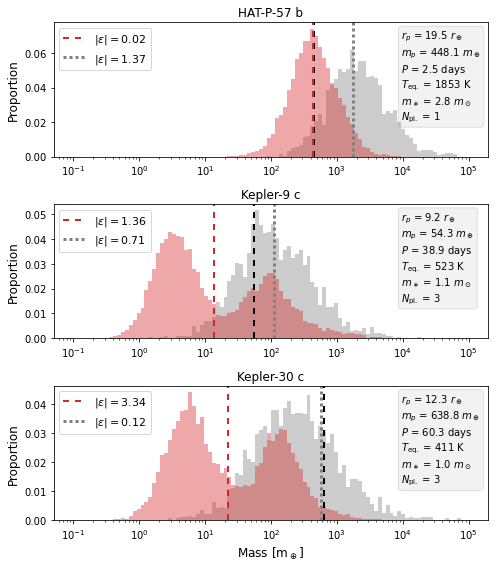

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(7, 8))

for n1, n2 in enumerate([104, 139, 65]):
    true_mass = true_masses[n2] * MJ
    imp_mass_FLO = imputed_masses_FLO[n2] * MJ
    imp_mass_TLG2020 = imputed_masses_TLG2020[n2] * MJ
    eps_FLO = individual_epsilons_FLO[n2]
    eps_TLG2020 = individual_epsilons_TLG2020[n2]
    
    ax[n1].hist(mass_distrib_TLG2020[n2]*MJ, bins=my_mass_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax[n1].hist(mass_distrib_FLO[n2]*MJ, bins=my_mass_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax[n1].axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    ax[n1].axvline(imp_mass_FLO, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_FLO):.2f}')
    ax[n1].axvline(imp_mass_TLG2020, ls=(0, (1, 1)), c='grey', lw=3, label=f'$|\\varepsilon|=${np.abs(eps_TLG2020):.2f}')
    ax[n1].set_xscale('log')
    ax[n1].set_ylabel('Proportion', size=12)
    ax[n1].legend(loc='upper left', prop={'size': 11})

    props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
    ax[n1].text(0.80, 0.95, generate_planet_short_bio(n2), transform=ax[n1].transAxes, fontsize=10, verticalalignment='top', bbox=props)
    ax[n1].set_title(test_names.iloc[n2])

ax[2].set_xlabel('Mass [m$_\oplus$]', size=12)

fig.tight_layout()
plt.savefig('additional_final_figures/comparison_tlg2020_transit_chosen_distributions3.pdf')
plt.show()

### C. B. RV planets

In [30]:
original_data = np.array(all_planets[['pl_radj', 'pl_bmassj', 'pl_orbper', 'pl_teq', 'pl_pnum', 'st_mass']])
log_original_data = np.copy(original_data)
for d in [0, 1, 2, 3, 5]:
    log_original_data[:, d] = np.log(original_data[:, d])  # take the log for all columns except pl_pnum

miss_data = np.copy(log_original_data)
for idx in dataidx[400:]:
    miss_data[idx, 0] = np.nan  # For RV case: hide the radius...
    miss_data[idx, 1] = np.nan  # and the mass!

norm_miss_data, norm_params = normalization(miss_data)
norm_log_original_data, _ = normalization(log_original_data, parameters=norm_params)

In [31]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20
knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')
knnxkde_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=10000)

In [32]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
r1 = norm_params['min_val'][0]
r2 = norm_params['max_val'][0]
m1 = norm_params['min_val'][1]
m2 = norm_params['max_val'][1]

rad_distrib_TLG2020 = np.zeros((150, 2000))
rad_distrib_FLO = np.zeros((150, 10000))
mass_distrib_TLG2020 = np.zeros((150, 2000))
mass_distrib_FLO = np.zeros((150, 10000))
for n in range(150):
    rad_distrib_TLG2020[n] = rv_dists[n, :, 0]
    mass_distrib_TLG2020[n] = rv_dists[n, :, 1]
    rad_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 0)] * (r2 + 1e-6) + r1)
    mass_distrib_FLO[n] = np.exp(knnxkde_samples[(dataidx[400+n], 1)] * (m2 + 1e-6) + m1)

In [33]:
nb_repeat = 100
estimates_TLG2020 = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet
estimates_FLO = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet

for n in range(nb_repeat):
    print(f'{n+1}/{nb_repeat}', end='\r', flush=True)
    cur_i = np.arccos(np.random.uniform()) * 90.0 / (np.pi / 2.0)  # random inclination in degrees
    estimates_TLG2020[0, :, n], estimates_TLG2020[1, :, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_TLG2020,
        mass_distrib=mass_distrib_TLG2020,
        true_masses=true_masses,
        incl=cur_i,
    )
    estimates_FLO[0, :, n], estimates_FLO[1, :, n] = convolution_TLG2020_fix_incl(
        rad_distrib=rad_distrib_FLO,
        mass_distrib=mass_distrib_FLO,
        true_masses=true_masses,
        incl=cur_i,
    )

In [34]:
epsilons_TLG2020 = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet
epsilons_FLO = np.zeros((2, 150, nb_repeat))  # radius and mass for each planet

epsilons_TLG2020[0] = np.expand_dims(np.log(true_radii), -1) - np.log(estimates_TLG2020[0])
epsilons_TLG2020[1] = np.expand_dims(np.log(true_masses), -1) - np.log(estimates_TLG2020[1])
print(epsilons_TLG2020.shape)
epsilons_FLO[0] = np.expand_dims(np.log(true_radii), -1) - np.log(estimates_FLO[0])
epsilons_FLO[1] = np.expand_dims(np.log(true_masses), -1) - np.log(estimates_FLO[1])
print(epsilons_FLO.shape)

(2, 150, 100)
(2, 150, 100)


In [35]:
my_rad_bins = np.geomspace(1e-1, 1e2, num=101)
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
my_weights_FLO = np.ones(mass_distrib_FLO.shape[-1]) / mass_distrib_FLO.shape[-1]
my_weights_TLG2020 = np.ones(mass_distrib_TLG2020.shape[-1]) / mass_distrib_TLG2020.shape[-1]

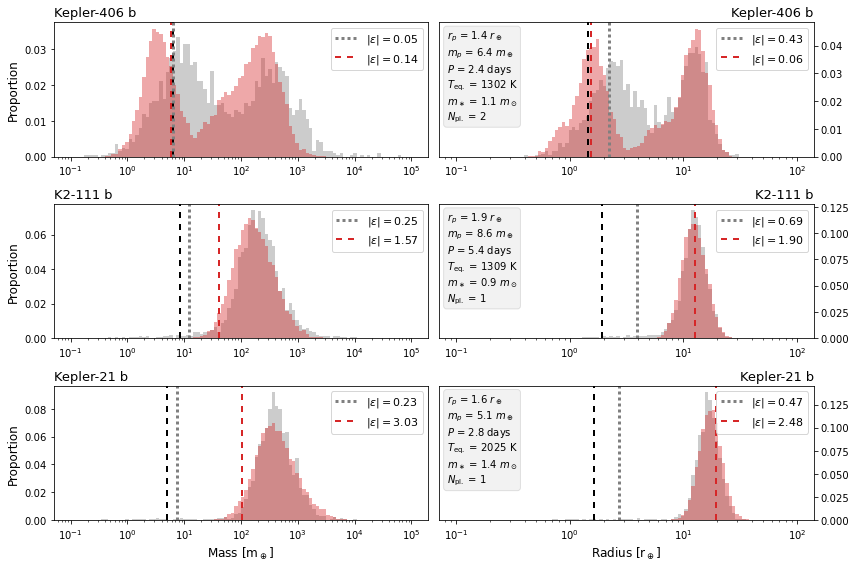

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8))

for n1, n2 in enumerate([112, 99, 129]):
    true_rad = true_radii[n2] * RJ
    true_mass = true_masses[n2] * MJ
    imp_rad_FLO = np.mean(estimates_FLO[0, n2, :], axis=-1) * RJ
    imp_mass_FLO = np.mean(estimates_FLO[1, n2, :], axis=-1) * MJ
    imp_rad_TLG2020 = np.mean(estimates_TLG2020[0, n2, :]) * RJ
    imp_mass_TLG2020 = np.mean(estimates_TLG2020[1, n2, :]) * MJ
    eps_rad_FLO = np.mean(epsilons_FLO[0, n2, :], axis=-1)
    eps_mass_FLO = np.mean(epsilons_FLO[1, n2, :], axis=-1)
    eps_rad_TLG2020 = np.mean(epsilons_TLG2020[0, n2, :])
    eps_mass_TLG2020 = np.mean(epsilons_TLG2020[1, n2, :])
    
    ax[n1][0].hist(mass_distrib_TLG2020[n2]*MJ, bins=my_mass_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax[n1][0].hist(mass_distrib_FLO[n2]*MJ, bins=my_mass_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax[n1][0].axvline(true_mass, ls=(0, (3, 3)), c='black', lw=2)
    ax[n1][0].axvline(imp_mass_TLG2020, ls=(0, (1, 1)), c='grey', lw=3, label=f'$|\\varepsilon|=${np.abs(eps_mass_TLG2020):.2f}')
    ax[n1][0].axvline(imp_mass_FLO, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_mass_FLO):.2f}')
    ax[n1][1].hist(rad_distrib_TLG2020[n2]*RJ, bins=my_rad_bins, weights=my_weights_TLG2020, color='grey', alpha=0.4)
    ax[n1][1].hist(rad_distrib_FLO[n2]*RJ, bins=my_rad_bins, weights=my_weights_FLO, color='C3', alpha=0.4)
    ax[n1][1].axvline(true_rad, ls=(0, (3, 3)), c='black', lw=2)
    ax[n1][1].axvline(imp_rad_TLG2020, ls=(0, (1, 1)), c='grey', lw=3, label=f'$|\\varepsilon|=${np.abs(eps_rad_TLG2020):.2f}')
    ax[n1][1].axvline(imp_rad_FLO, ls=(0, (3, 3)), c='C3', lw=2, label=f'$|\\varepsilon|=${np.abs(eps_rad_FLO):.2f}')
    for n3 in range(2):
        ax[n1][n3].set_xscale('log')
        ax[n1][n3].legend(loc='upper right', prop={'size': 11})
    ax[n1][0].set_ylabel('Proportion', size=12)
    ax[n1][0].set_title(test_names.iloc[n2], loc='left', size=13)
    ax[n1][1].set_title(test_names.iloc[n2], loc='right', size=13)
    ax[n1][1].yaxis.tick_right()

    props = dict(boxstyle='round', facecolor='grey', alpha=0.1)
    ax[n1][1].text(0.02, 0.95, generate_planet_short_bio(n2), transform=ax[n1][1].transAxes, fontsize=10, verticalalignment='top', bbox=props)

ax[2][0].set_xlabel('Mass [m$_\oplus$]', size=12)
ax[2][1].set_xlabel('Radius [r$_\oplus$]', size=12)
    
fig.tight_layout()
plt.savefig('additional_final_figures/comparison_tlg2020_rv_chosen_distributions3.pdf')
plt.show()